In [1]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

Using TensorFlow backend.


In [2]:
import warnings
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt

In [3]:
warnings.filterwarnings("ignore")

In [16]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax  = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding+data, label='Prediction')
        plt.legend()
        
    plt.show()

In [5]:
def load_data(filename, seq_len, normalize_window):
    f = open(filename, 'r').read()
    
    data = f.split('\n')
    
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index : index+sequence_length])
        
    if normalize_window:
        result = normalize_windows(result)
        
    result = np.array(result)
    
    
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]
    
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    x_test  = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return [x_train, y_train, x_test, y_test]

In [6]:
def normalize_windows(window_data) : 
    normalized_data = []
    for window in window_data:
        normalized_window = [((float(p) / float(window[0])) -1 ) for p in window]
        normalized_data.append(normalized_window)
        
    return normalized_data

In [7]:
def build_model(layers):
    model = Sequential()
    model.add(LSTM(
        input_dim = layers[0],
        output_dim = layers[1],
        return_sequences = True
    ))
    model.add(LSTM(
        layers[2],
        return_sequences = False
    ))
    model.add(Dense(
        output_dim = layers[3]
    ))
    
    model.add(Activation("linear"))
    
    start = time.time()
    
    model.compile(loss = "mse", optimizer="rmsprop")
    print("Compilation Time: ", time.time() - start)
    
    return model
    

In [8]:
def predict_point_by_point(model, data):
    predicted = mnodel.predict(data)
    predicted = np.reshape(predicted, (predicted.size, ))
    return predicted

In [18]:
def predict_sequence_full (model, data, window_size):
    
    curr_frame = data[0]
    predicted = []
    
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis, :, :])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        
    return predicted


In [28]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    prediction_seqs = []
    
    for i in range(len(data)//prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
            
        prediction_seqs.append(predicted)
        
    return prediction_seqs

### Steps

In [11]:
X_train, y_train, X_test, y_test = load_data('sp500.csv', 50, True)

In [12]:
model = Sequential()

model.add(LSTM(
    input_dim = 1,
    output_dim = 50,
    return_sequences = True
))

model.add(Dropout(0.2))
model.add(LSTM(
    100,
    return_sequences = False
))

model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1
))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')

print('compilation time:', time.time() - start)

compilation time: 0.04700469970703125


### Train the model

In [13]:
model.fit(
    X_train,
    y_train,
    batch_size = 512,
    nb_epoch = 1,
    validation_split = 0.05
)

Train on 3523 samples, validate on 186 samples
Epoch 1/1
3523/3523 [==============================] - 12s - loss: 0.0022 - val_loss: 0.0010


### Plot the model

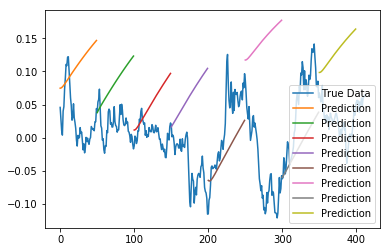

In [30]:
predictions = predict_sequences_multiple(model, X_test, 50, 50)
plot_results_multiple(predictions, y_test, 50)